# Build CSD

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ODLintake
from xrsignal import xrsignal
from dask.distributed import Client
from OOI_hydrophone_cloud import utils as hdata_utils
import scipy
from scipy import signal
import hvplot.xarray
import xrft

%load_ext autoreload
%autoreload 2

In [2]:
client = Client()
client

<Client: 'tcp://127.0.0.1:40719' processes=8 threads=32, memory=62.80 GiB>

## Open Hydrophone Data

In [3]:
lf_hdata = ODLintake.open_ooi_lfhydrophones()

In [4]:
lf_hdata_slice = hdata_utils.slice_ds(lf_hdata, pd.Timestamp('2017-01-01'), pd.Timestamp('2017-02-01'), include_coord=False)[['AXCC1','AXEC2']]

##### interesting side quest
- it looks like the welch method is a *way* to calculate NCCF, but there isn't whitening.
- it roughly appears that some EGF info is there...


In [10]:
lf_hdata_slice = hdata_utils.slice_ds(lf_hdata, pd.Timestamp('2017-01-01'), pd.Timestamp('2017-01-01T12:00:00'), include_coord=False)[['AXCC1','AXEC2']].load().interpolate_na(dim='time', method='cubic')

In [11]:
b,a = signal.butter(4, [0.03, 0.9], btype='bandpass')

lf_hdata_filt = lf_hdata_slice.map(xrsignal.filtfilt, dim='time', a=a, b=b)

In [12]:
Sxy = xrsignal.__csd_chunk(lf_hdata_filt, dim='time', nperseg=11999)
Sxy_full = np.hstack((np.flip(Sxy[:,1:]).values, Sxy[:,:].values)).squeeze()
Rxy = scipy.fft.ifft(Sxy_full)

Text(0.5, 1.0, 'Rxy')

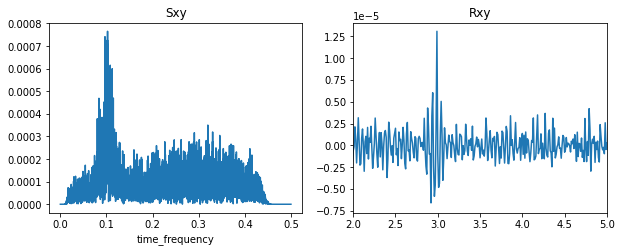

In [27]:
fig = plt.figure(figsize=(10,3.5))
plt.subplot(1,2,1)
np.abs(Sxy).plot()
plt.title('Sxy')

plt.subplot(1,2,2)
tau = np.linspace(0, 60 ,len(Rxy))
plt.plot(tau, Rxy)
plt.xlim([2,5])
plt.title('Rxy')

## Build csd

In [9]:
Sxy = xrsignal.csd(1e6*lf_hdata_slice, dim='time', fs=200, dB=True, average='median', nperseg=2048).compute()
Sxy = Sxy.assign_coords({'time':np.arange(Sxy.sizes['time'])})

In [10]:
Sxy.hvplot.image(x='time', cmap='inferno', rasterize=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


:DynamicMap   []
   :Image   [time,time_frequency]   (psd across time dimension)